### Embedding for unsupervised clustering
In this notebook, we use a subset of the Top 10000 Popular Movies Dataset to calculate embeddings on movie descriptions and then apply kmeans to find similar clusters. Once we have these clusters, we'll use a prompt to extract the topics from each cluster.

In [1]:
# Import Python libraries
import os
import openai
from Utilities.envVars import *
from openai import OpenAI, AzureOpenAI, AsyncAzureOpenAI

# # Set OpenAI API key and endpoint
# openai.api_type = "azure"
# openai.api_version = OpenAiVersion
# openai_api_key = OpenAiKey
# assert openai_api_key, "ERROR: Azure OpenAI Key is missing"
# openai.api_key = openai_api_key
# openAiEndPoint = f"{OpenAiEndPoint}"
# openai.api_base = openAiEndPoint

azure_endpoint  = f"{OpenAiEndPoint}"
api_key = OpenAiKey
api_version = OpenAiVersion

client = AzureOpenAI(
    api_key=api_key,  
    api_version=api_version,
    #base_url=f"{os.getenv('OpenAiWestUsEp')}openai/deployments/{os.getenv('OpenAiGpt4v')}/extensions",
    azure_endpoint=azure_endpoint,
)

In [2]:
#%pip install matplotlib
#%pip install plotly
#%pip install scipy
#%pip install scikit-learn

In [4]:
import os
import tiktoken
import openai
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from openai import Embedding
from tenacity import retry, wait_random_exponential, stop_after_attempt

In [20]:
encoding = tiktoken.get_encoding('cl100k_base')

In [21]:
# Read the data
df = pd.read_csv('./Data/CSV/movies.csv')
df.head()

,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss..."
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.
3,347847.0,en,The Sand,14.172,2015-08-28,5.1,157.0,['Horror'],Just when you thought it was safe to go back i...,0.000000e+00,84.0,This Beach is Killer
4,739542.0,en,America: The Motion Picture,98.542,2021-06-30,5.8,130.0,"['Action', 'Comedy', 'History', 'Animation', '...",A chainsaw-wielding George Washington teams wi...,0.000000e+00,98.0,This summer they're redrawing history.


Next, let's create a new column and calculate how many tokens each embedding would cost. This allows us to get an estimate how much we'd pay to create embeddings on the whole dataset.

In [22]:
# add a new column to the dataframe where you put the token count of the review
df = df.assign(token_count=df['overview'].apply(lambda x: len(encoding.encode(x))))

# print the first 5 rows of the dataframe, then also the total number of tokens
total_tokens = df['token_count'].sum()

cost_for_embeddings = total_tokens / 1000 * 0.0004
print(f"Test would cost ${cost_for_embeddings} for embeddings")
#df = df.head(1)

Test would cost $0.0117564 for embeddings


Let's define our embedding method. Please note the use of tenacity for having an automated retry mechanism, in case we hit the TPS limits of Azure OpenAI Service.

In [17]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(10))
def get_embedding(text) -> list[float]:
    text = text.replace("\n", " ")
    #return openai.Embedding.create(input=text, engine=OpenAiEmbedding)["data"][0]["embedding"]
    return client.embeddings.create(input =text, model= OpenAiEmbedding).data[0].embedding

In [24]:
#Let's creating the embeddings
df = df.assign(embedding=df['overview'].apply(lambda x: get_embedding(x)))
df.head()

,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline,token_count,embedding
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss...",62,"[-0.016773954033851624, -0.013943992555141449,..."
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…,35,"[-0.006633164826780558, -0.0225320216268301, -..."
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.,36,"[-0.011420898139476776, -0.028828712180256844,..."
3,347847.0,en,The Sand,14.172,2015-08-28,5.1,157.0,['Horror'],Just when you thought it was safe to go back i...,0.000000e+00,84.0,This Beach is Killer,124,"[-0.0013517639599740505, -0.036952193826436996..."
4,739542.0,en,America: The Motion Picture,98.542,2021-06-30,5.8,130.0,"['Action', 'Comedy', 'History', 'Animation', '...",A chainsaw-wielding George Washington teams wi...,0.000000e+00,98.0,This summer they're redrawing history.,32,"[-0.006491174455732107, -0.020530225709080696,..."


In [25]:
# Next, let's create clusters on the embeddings using KMeans. In this case, we'll go for 5 clusters, knowing that this might be wrong.
# train k-means on df embeddings
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(df['embedding'].to_list())
df = df.assign(cluster=kmeans.labels_)
df.head()

,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline,token_count,embedding,cluster
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss...",62,"[-0.016773954033851624, -0.013943992555141449,...",0
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…,35,"[-0.006633164826780558, -0.0225320216268301, -...",4
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.,36,"[-0.011420898139476776, -0.028828712180256844,...",2
3,347847.0,en,The Sand,14.172,2015-08-28,5.1,157.0,['Horror'],Just when you thought it was safe to go back i...,0.000000e+00,84.0,This Beach is Killer,124,"[-0.0013517639599740505, -0.036952193826436996...",3
4,739542.0,en,America: The Motion Picture,98.542,2021-06-30,5.8,130.0,"['Action', 'Comedy', 'History', 'Animation', '...",A chainsaw-wielding George Washington teams wi...,0.000000e+00,98.0,This summer they're redrawing history.,32,"[-0.006491174455732107, -0.020530225709080696,...",2


(500, 1536)


C:\Users\astalati\AppData\Local\Temp\ipykernel_14428\87599613.py:21: RuntimeWarning: Mean of empty slice.
  avg_x = xs.mean()
c:\Users\astalati\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\astalati\AppData\Local\Temp\ipykernel_14428\87599613.py:22: RuntimeWarning: Mean of empty slice.
  avg_y = ys.mean()


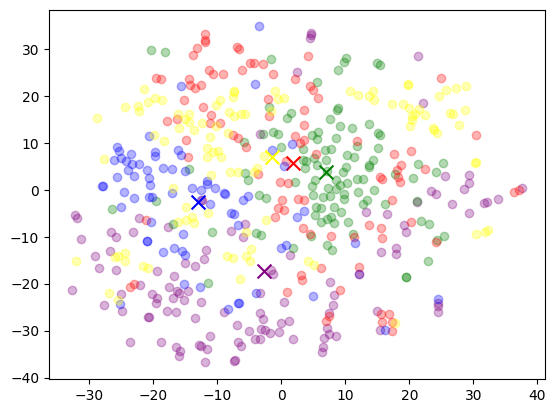

In [26]:
# Now that we have a cluster per row, let's use t-SNE to project our embeddings into 2d space and visualize the clusters.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)

matrix = np.vstack(df.embedding.values)
print(matrix.shape)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow", 'black', 'orange', 'brown', 'pink', 'grey']):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

We have all kinds of movies and with only 5 clusters, this might not be ideal. However, if you look closely, you can make up some rough shape that resembles a cluster. Also, movies might fall into two or more categories, so it kind of makes sense.

Lastly, let's take a few examples from each cluster, send them to OpenAI and get the common theses extracted:

In [28]:
# take 10 movies from each cluster and write a prompt that asks what these have in common
# ideally you would use more movies than 10, but this is just a demo
for i in range(n_clusters):
    reviews = df[df['cluster'] == i]['overview'].sample(10)
    reviews = "\n".join(reviews.values.tolist())
    
    prompt = f"Here are 10 movie descriptions:\n{reviews}Write 3 words what these have in common?"
    #print(prompt)
    messages=[
        {"role": "system", "content": prompt}
    ]

    # Create a completion for the provided prompt and parameters
    # To know more about the parameters, checkout this documentation: https://learn.microsoft.com/en-us/azure/cognitive-services/openai/reference
    completion = client.chat.completions.create(
                    messages=messages,
                    temperature=0,
                    max_tokens=500,
                    model=OpenAiChat)
    
    response = completion.choices[0].message.content.strip(" \n")
    print(f"Cluster {i} topics: {response}")
    movies = df[df['cluster'] == i]['original_title'].sample(25)
    print(f"Movies from cluster {i}: {', '.join(movies.values.tolist())}")
    print("================")

Cluster 0 topics: family, journey, adventure
Movies from cluster 0: Coco, The Beach, Fantastic Beasts and Where to Find Them, Tarzan, Evolution, Arctic Dogs, Splice, Thale, 불어라 검풍아, Legends of the Fall, The Core, The Empire Strikes Back, Ben-Hur, Perfume: The Story of a Murderer, The Rocketeer, Babel, Treasure Island, Hidden Figures, Minions, Isle of Dogs, The Princess and the Frog, Cats, Immortals, Futurama: Bender's Big Score, The Road to El Dorado
Cluster 1 topics: romantic, secrets, revenge
Movies from cluster 1: 맛있는 비행, Fame, To All the Boys I've Loved Before, The Handmaid's Tale, Sleeping With My Student, When Harry Met Sally..., Behaving Badly, Women, John Tucker Must Die, Saint Maud, Dragonfly, Christmas Wedding Planner, The Sisterhood of the Traveling Pants, たまこラブストーリー, Mary Shelley, Outlier, Veronica Mars, Nineteen Eighty-Four, When the Bough Breaks, Work It, Jane Eyre, Unicorn Store, Down a Dark Hall, Coco avant Chanel, Ramona and Beezus
Cluster 2 topics: Animals, Relationsh

Using the embeddings to build a simple recommendation system

In [32]:
from scipy.spatial.distance import cdist

# Let's pick a movie that exists in df, keeping in mind we only have 500 movies in it!
movie = "Frozen"

# get embedding for movie
e = df[df['original_title'] == movie]['embedding'].values[0]

# get cosine similarity between movie and all other movies and sort ascending
#similarities = df['embedding'].apply(lambda x: distances_from_embeddings(x, e))
similarities = cdist(df['embedding'].to_list(), [e], metric='cosine')

# get most similar movies
movies = df.assign(similarity=similarities).sort_values(by='similarity', ascending=False)[['original_title', 'similarity', 'overview']]
movies[1:6]

,original_title,similarity,overview
118,The Lincoln Lawyer,0.304418,A lawyer conducts business from the back of hi...
392,Mayhem,0.301695,A virus spreads through an office complex caus...
110,The Last Castle,0.298455,A court-martialed general rallies together 120...
212,The Great Hack,0.287203,Data—arguably the world’s most valuable asset—...
9,They Came Together,0.285718,A small business owner is about to lose her sh...
